In [239]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.transform import Rotation as Rot

In [240]:
def rot_mat_2d(angle):
    """
    Create 2D rotation matrix from an angle

    Parameters
    ----------
    angle :

    Returns
    -------
    A 2D rotation matrix

    Examples
    --------
    >>> angle_mod(-4.0)


    """
    return Rot.from_euler('z', angle).as_matrix()[0:2, 0:2]

def plot_covariance_ellipse(x, y, cov, chi2=3.0, color="-r", ax=None):
    """
    This function plots an ellipse that represents a covariance matrix. The ellipse is centered at (x, y) and its shape, size and rotation are determined by the covariance matrix.

    Parameters:
    x : (float) The x-coordinate of the center of the ellipse.
    y : (float) The y-coordinate of the center of the ellipse.
    cov : (numpy.ndarray) A 2x2 covariance matrix that determines the shape, size, and rotation of the ellipse.
    chi2 : (float, optional) A scalar value that scales the ellipse size. This value is typically set based on chi-squared distribution quantiles to achieve certain confidence levels (e.g., 3.0 corresponds to ~95% confidence for a 2D Gaussian). Defaults to 3.0.
    color : (str, optional) The color and line style of the ellipse plot, following matplotlib conventions. Defaults to "-r" (a red solid line).
    ax : (matplotlib.axes.Axes, optional) The Axes object to draw the ellipse on. If None (default), a new figure and axes are created.

    Returns:
    None. This function plots the covariance ellipse on the specified axes.
    """
    eig_val, eig_vec = np.linalg.eig(cov)

    if eig_val[0] >= eig_val[1]:
        big_ind = 0
        small_ind = 1
    else:
        big_ind = 1
        small_ind = 0
    a = math.sqrt(chi2 * eig_val[big_ind])
    b = math.sqrt(chi2 * eig_val[small_ind])
    angle = math.atan2(eig_vec[1, big_ind], eig_vec[0, big_ind])
    plot_ellipse(x, y, a, b, angle, color=color, ax=ax)


def plot_ellipse(x, y, a, b, angle, color="-r", ax=None, **kwargs):
    """
    This function plots an ellipse based on the given parameters.

    Parameters
    ----------
    x : (float) The x-coordinate of the center of the ellipse.
    y : (float) The y-coordinate of the center of the ellipse.
    a : (float) The length of the semi-major axis of the ellipse.
    b : (float) The length of the semi-minor axis of the ellipse.
    angle : (float) The rotation angle of the ellipse, in radians.
    color : (str, optional) The color and line style of the ellipse plot, following matplotlib conventions. Defaults to "-r" (a red solid line).
    ax : (matplotlib.axes.Axes, optional) The Axes object to draw the ellipse on. If None (default), a new figure and axes are created.
    **kwargs: Additional keyword arguments to pass to plt.plot or ax.plot.

    Returns
    ---------
    None. This function plots the ellipse based on the specified parameters.
    """

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    px = [a * math.cos(it) for it in t]
    py = [b * math.sin(it) for it in t]
    fx = rot_mat_2d(angle) @ (np.array([px, py]))
    px = np.array(fx[0, :] + x).flatten()
    py = np.array(fx[1, :] + y).flatten()
    if ax is None:
        plt.plot(px, py, color, **kwargs)
    else:
        ax.plot(px, py, color, **kwargs)

In [241]:
class EKF:
    def __init__(self):
        self.dt = 0.1
        self.cov = np.zeros((3,3))
        self.Q_k = np.array([(0.5, 0.01, 0.01),
                             (0.01, 0.5, 0.01), 
                             (0.01, 0.01, 0.2)]) * 0.01 # Motion model cov matrix

    # State, control input
    def update(self, X, u):
        cos_t = np.cos(X[2])
        sin_t = np.sin(X[2])

        # Estimate state
        pose_mean_hat = X + dt * np.array((u[0] * cos_t, u[0] * sin_t, u[1]))

        # Linearize model
        H_k = np.array(((1, 0, -dt * u[0] * sin_t), (0, 1, dt * u[0] * cos_t), (0, 0, 1)))

        # Predict covariance
        cov_hat = H_k @ self.cov @ H_k.T + self.Q_k

        # TODO Observation model
        self.cov = cov_hat
        return pose_mean_hat, cov_hat

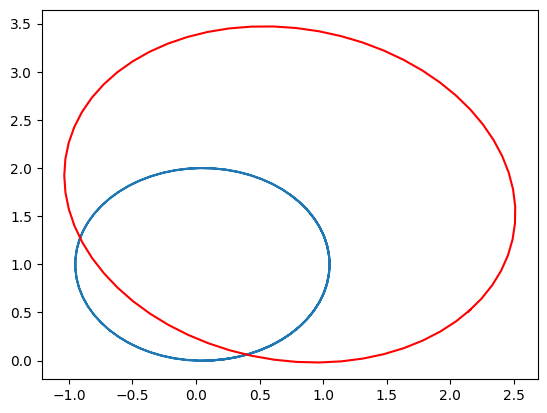

In [242]:
ekf = EKF()
pose = np.zeros(3)
path, cov_history = [], []
for _ in range(150):
    pose, cov = ekf.update(pose, np.ones(2))
    path.append(pose)
    cov_history.append(cov)

fig, ax = plt.subplots()
ax.plot(*zip(*np.array(path)[:,:2]))
plot_covariance_ellipse(pose[0], pose[1], cov[:2,:2])

In [243]:
cov[:2,:2]

array([[ 1.0493471 , -0.11701484],
       [-0.11701484,  1.01563107]])

In [244]:
pose

array([ 0.73773024,  1.72570687, 15.        ])

In [245]:
X = np.zeros(3)
u = np.ones(2)
dt = 0.1
cov = np.zeros((3,3))
Q_k = np.array([(0.5, 0.01, 0.01), (0.01, 0.5, 0.01), (0.01, 0.01, 0.2)]) # Motion model cov matrix

cos_t = np.cos(X[2])
sin_t = np.sin(X[2])
# Estimate state
mu_hat = X + dt * np.array((u[0] * cos_t, u[0] * sin_t, u[1]))

# Linearize model
H_k = np.array(((1, 0, -dt * u[0] * sin_t), (0, 1, dt * u[0] * cos_t), (0, 0, 1)))

# Predict covariance
cov_hat = H_k * cov * H_k.T + Q_k

# Observation model would go here


In [277]:
from collections import namedtuple

TagDetection = namedtuple('TagDetection', 'idx range bearing')

# From probabilistic robotics
class EKF_SLAM_Correspondence():
    def __init__(self, R, Q, valid_tags):
        self.max_landmarks = len(valid_tags)
        self.N2 = self.max_landmarks * 2
        self.state = np.zeros((3 + self.N2))

        # 3x3 -> robot states
        self.sigma = 1e-4 * np.ones((3 + self.N2, 3 + self.N2))
        for i in range(3, 3 + self.N2):
            # Large values for feature variances, as we do not have any info.
            self.sigma[i][i] = 1e5

        # State cov matrix
        self.R = R

        # Meas cov matrix
        self.Q = Q

        # Kalman gain
        self.K = np.zeros((3,3))

        self.valid_tags = valid_tags
        self.observed_tags = set()
        self.last_time = None

    # Control Input -> [v, omega]
    def update(self, u, time):
        if self.last_time is None:
            self.last_time = time
            return

        dt = time - self.last_time
        v, omega = u
        t_cos, t_sin = np.cos(self.state[2]), np.sin(self.state[2])
        x_t = self.state[0] + v * t_cos * dt
        y_t = self.state[1] + v * t_sin * dt
        theta_t = self.state[2] + omega * dt

        self.state[:3] = np.array((x_t, y_t, theta_t))

        # Linearize with Jacobian
        G = np.identity((3 + self.N2))
        G[0][2] = dt * -v * t_sin
        G[1][2] = dt * v * t_cos

        # Covariance update
        self.sigma = G @ self.sigma @ G.T
        self.sigma[0:3,0:3] += self.R
        self.last_time = time
        
    def measurement_update(self, z: TagDetection):
        if z.idx not in self.valid_tags:
            return

        x, y, theta = self.state[:3]

        # Tag id != index of tag in state.
        # Index is given by order from valid_tags
        tag_state_index = self.valid_tags.index(z.idx)
        #print(tag_state_index)
        
        if z.idx not in self.observed_tags:
            # Initialize tag location in state vector
            x_l = x + z.range * np.cos(z.bearing + theta)
            y_l = y + z.range * np.sin(z.bearing + theta)
            self.state[2 * tag_state_index + 1 : 2 * tag_state_index + 3] = x_l, y_l
            self.observed_tags.add(z.idx)
        else:
            x_l, y_l = self.state[2 * tag_state_index + 1 : 2 * tag_state_index + 3] 

        # Measurement update
        dx = x_l - x
        dy = y_l - y
        q = dx ** 2 + dy ** 2
        expected_range = np.hypot(dx, dy)
        expected_bearing = np.arctan2(dy, dx) - theta

        # Linearize model
        F = np.zeros((5, 3 + self.N2))
        F[0][0], F[1][1], F[2][2] = 1, 1, 1
        F[3][2 * tag_state_index + 1] = 1
        F[3][2 * tag_state_index + 2] = 1

        H = np.array([
            (-dx / expected_range, -dy / expected_range, 0, dx / expected_range, dy / expected_range),
            (dy / q, -dx / q, -1, -dy / q, dx / q),
            np.zeros(5)]) @ F

        # Gain update
        self.K = self.sigma @ H.T @ np.linalg.inv(H @ self.sigma @ H.T + self.Q)

        # Prediction
        self.state = self.state + self.K @ np.array([z.range - expected_range, z.bearing - expected_bearing, 0])

        # Cov update
        self.sigma = (np.identity(self.sigma.shape[0]) - self.K @ H) @ self.sigma

In [252]:
def load_dataset(dataset):
    # Barcodes: [Subject#, Barcode#]
    barcodes_data = np.loadtxt(dataset + "/Barcodes.dat")
    # Ground truth: [Time[s], x[m], y[m], orientation[rad]]
    groundtruth = np.loadtxt(dataset + "/Groundtruth.dat")
    # Landmark ground truth: [Subject#, x[m], y[m]]
    landmark_groundtruth_data = np.loadtxt(dataset + "/Landmark_Groundtruth.dat")
    # Measurement: [Time[s], Subject#, range[m], bearing[rad]]
    measurement_data = np.loadtxt(dataset + "/Measurement.dat")
    # Odometry: [Time[s], forward_V[m/s], angular _v[rad/s]]
    odometry_data = np.loadtxt(dataset + "/Odometry.dat")

    # Odometry data is represented by -1 tag id
    odom_data = np.insert(odometry_data, 1, -1, axis=1)
    data = np.concatenate((odom_data, measurement_data), axis=0)
    
    data = data[np.argsort(data[:, 0])]
    return data, groundtruth
    
data, groundtruth = load_dataset('dataset')
groundtruth[:, 1:3] = groundtruth[:,1:3] - groundtruth[0,1:3]
tags = set([t for t in np.unique(data.T[1]) if t != -1])
print(tags)

{5.0, 7.0, 9.0, 14.0, 16.0, 18.0, 23.0, 25.0, 27.0, 32.0, 36.0, 45.0, 54.0, 61.0, 63.0, 70.0, 72.0, 81.0, 90.0}


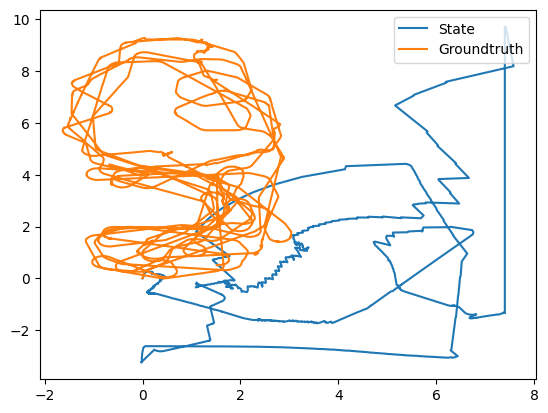

In [282]:
R = np.diagflat(np.array([5, 5, 100]) ** 2)
Q = np.diagflat(np.array((110, 110, 1e16)) ** 2)
slam = EKF_SLAM_Correspondence(R, Q, list(tags))
states = []
data_start, data_stop = 800, 3200
for (time, idx, d0, d1) in data[data_start:data_stop]:
    #print(idx, d0, d1)
    if idx == -1:
        # Odometry update
        pass
        slam.update(np.array((d0, d1)), time)
    else:
        slam.measurement_update(TagDetection(idx, d0, d1))
    states.append(slam.state.copy())

fig, ax = plt.subplots()
ax.plot(*zip(*np.array(states)[:,:2]), label="State")
ax.plot(*zip(*np.array(groundtruth[:,1:3])), label="Groundtruth")
ax.legend()

In [269]:
groundtruth[0]

array([1.28897184e+09, 0.00000000e+00, 0.00000000e+00, 1.44849633e+00])

In [250]:
states

[array([0.00142, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]),
 array([0.00284, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]),
 array([0.00284, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]),
 array([0.00426, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]),
 array([0.00568, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]),
 array([0.0071, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    ]),
 array([0.00852, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]),
 array([0.00852, 0.     , 0.     , 0.     , 0.     , 0.     , 0.    